In [1]:
from random import random, seed
from celmech import Poincare, PoincareHamiltonian
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# sympy for pretty printing, symbolic manipulation
from sympy import init_printing
init_printing()

In [2]:
def packed_sim(Nseed):
    seed(Nseed)
    sim = rebound.Simulation()
    sim.add(m=1)
 
    sim.G = 4*np.pi*np.pi
    a1 = 1
    m1 = 10**(6*random()-10) # uniform in log space between 10**[-10, -4]
    m2 = 10**(6*random()-10)
    m3 = 10**(6*random()-10) 
    RH = a1*((m1+m2)/3.)**(1./3.)
    beta = 4 + 6*random() # uniform on [4, 10] mutual hill radii separation.
    sim.add(m=m1,a=a1)
    sim.add(m=m2,a=a1+beta*RH, l=0)
    sim.add(m=m3,a=a1+2*beta*RH, l=0)

    sim.move_to_com()

    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    if sim.particles[1].a/sim.particles[2].a > 0.98:
        return packed_sim(Nseed+1000)
    return sim 

In [3]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def averaging_error(Nseed, plot=True, average=True):
    sim = packed_sim(Nseed)
    ps = sim.particles

    o = sim.calculate_orbits(jacobi_masses=True)
    a10 = o[0].a
    a20 = o[1].a
    a30 = o[2].a
    tsyn = 2*np.pi/(o[0].n-o[1].n)
    #print(tsyn)
    tmax = 30*tsyn
    Nout = 100
    times = np.linspace(0, tmax, Nout)

    pvars = Poincare.from_Simulation(sim, average=average)
    Hsim = PoincareHamiltonian(pvars)

    #print(ps[1].m, ps[2].m)
    
    Nsma = np.zeros((3,Nout))
    Hsma = np.zeros((3,Nout))

    for i,t in enumerate(times):
        # Store N-body data
        o = sim.calculate_orbits(jacobi_masses=True)
        Nsma[0,i]=o[0].a
        Nsma[1,i]=o[1].a
        Nsma[2,i]=o[2].a
        
        ps = Hsim.particles
        Hsma[0,i]=ps[1].a
        Hsma[1,i]=ps[2].a
        Hsma[2,i]=ps[3].a

        sim.integrate(t)
        Hsim.integrate(t)
        
    Nmad1 = mad((Nsma[0]-a10)/a10)
    Nmad2 = mad((Nsma[1]-a20)/a20)
    Nmad3 = mad((Nsma[2]-a30)/a30)
    
    #print(Nmad1, Nmad2)
    Nmed1 = np.median((Nsma[0]-a10)/a10)
    Pmed1 = np.median((Hsma[0]-a10)/a10)
    err1 = abs(Pmed1-Nmed1)/Nmad1
    
    Nmed2 = np.median((Nsma[1]-a20)/a20)
    Pmed2 = np.median((Hsma[1]-a20)/a20)
    err2 = abs(Pmed2-Nmed2)/Nmad2
    
    Nmed3 = np.median((Nsma[2]-a30)/a30)
    Pmed3 = np.median((Hsma[2]-a30)/a30)
    err3 = abs(Pmed3-Nmed3)/Nmad3
    
    if plot is True:
        fig,ax=plt.subplots()

        ax.plot(times,(Hsma[0]-a10)/a10,'r--')
        ax.plot(times,(Hsma[1]-a20)/a20,'k--')
        ax.plot(times,(Hsma[2]-a30)/a30,'g--')

        ax.plot(times,(Nsma[0]-a10)/a10,'r')
        ax.plot(times,(Nsma[1]-a20)/a20,'k')
        ax.plot(times,(Nsma[2]-a30)/a30,'g')

        ax.plot(times,[Nmed1]*len(times),'r', alpha=0.5)
        ax.plot(times,[Nmed2]*len(times),'k', alpha=0.5)
        ax.plot(times,[Nmed3]*len(times),'g', alpha=0.5)
    return max(err1, err2, err3)

We plot the deviations of the semimajor axes from the initial osculating value in the N-body simulation. Solid line is the median of the N-body, dashed is the correction from averaging the synodic terms. We compare the difference between solid and dashed to the MAD of the N-body values (i.e. the median of the absolute deviations from the median, in order to capture the low amplitude variations and exclude the big kicks at conjunctions).

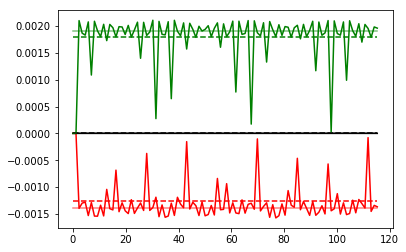

In [4]:
averaging_error(8)

The median error as defined above over 100 random realizations starting at conjunction (with maximum correction), after averaging (we take the median since some N-body simulations go unstable and skew results a lot):

In [5]:
%%time
errs = np.array([averaging_error(Nseed, plot=False) for Nseed in range(100)])
print(np.median(errs))

1.96392133245
CPU times: user 4.67 s, sys: 32 ms, total: 4.7 s
Wall time: 4.71 s


If we don't do the averaging, we do much worse

In [6]:
%%time
errs = np.array([averaging_error(Nseed, plot=False, average=False) for Nseed in range(100)])
print(np.median(errs))

22.2794944237
CPU times: user 4.59 s, sys: 39.5 ms, total: 4.63 s
Wall time: 4.65 s


In [7]:
def pratios(Nseed):
    sim = get_sim(Nseed)
    ps = sim.particles

    pratio = ps[1].P/ps[2].P
    print('pratio = ', pratio)
    res = resonant_period_ratios(pratio-0.1, pratio+0.1, 5)
    ps = sim.particles
    for r in res:
        j = r[1]
        k = r[1]-r[0]
        print(j, ':', j-k, j*ps[2].n-(j-k)*ps[1].n)
    print('***')               